In [7]:
!pip install faker


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import random
import pandas as pd
from faker import Faker

fake = Faker()

# Generar Autores
def generate_authors(n=100):
    authors = []
    for _ in range(n):
        authors.append({
            "id_autor": _ + 1,
            "nombre": fake.name(),
            "nacionalidad": fake.country(),
            "fecha_nacimiento": fake.date_of_birth(minimum_age=25, maximum_age=80)
        })
    return pd.DataFrame(authors)

# Generar Libros
def generate_books(n=500, author_ids=None):
    genres = ["Novela", "Ciencia ficción", "Fantasía", "Misterio", "Biografía", "Historia", "Poesía", "Ensayo"]
    books = []
    for i in range(n):
        books.append({
            "id_libro": i + 1,
            "titulo": fake.sentence(nb_words=5),
            "id_autor": random.choice(author_ids),
            "genero": random.choice(genres),
            "anio_publicacion": random.randint(1900, 2024),
            "disponible": random.choice([True, False])
        })
    return pd.DataFrame(books)

# Generar Usuarios
def generate_users(n=150):
    users = []
    for i in range(n):
        users.append({
            "id_usuario": i + 1,
            "nombre": fake.name(),
            "email": fake.email(),
            "telefono": fake.phone_number()
        })
    return pd.DataFrame(users)

# Generar Préstamos
def generate_loans(n=300, book_ids=None, user_ids=None):
    loans = []
    for i in range(n):
        loan_date = fake.date_this_decade(before_today=True, after_today=False)
        loans.append({
            "id_prestamo": i + 1,
            "id_libro": random.choice(book_ids),
            "id_usuario": random.choice(user_ids),
            "fecha_prestamo": loan_date,
            "fecha_devolucion": fake.date_between(start_date=loan_date, end_date="+30d")
        })
    return pd.DataFrame(loans)

# Generar Datos
authors_df = generate_authors(100)
books_df = generate_books(500, author_ids=authors_df['id_autor'].tolist())
users_df = generate_users(150)
loans_df = generate_loans(300, book_ids=books_df['id_libro'].tolist(), user_ids=users_df['id_usuario'].tolist())

# Guardar en CSV
authors_df.to_csv("authors.csv", index=False)
books_df.to_csv("books.csv", index=False)
users_df.to_csv("users.csv", index=False)
loans_df.to_csv("loans.csv", index=False)


Crear base de datos

In [9]:
!pip install mysql-connector-python


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import mysql.connector

# Conectar a MySQL
conn = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="PruebaEstu2012"
)
cursor = conn.cursor()

# Crear Base de Datos y Tablas
cursor.execute("CREATE DATABASE IF NOT EXISTS Biblioteca;")
cursor.execute("USE Biblioteca;")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Autores (
    id_autor INT PRIMARY KEY,
    nombre VARCHAR(255) NOT NULL,
    nacionalidad VARCHAR(100),
    fecha_nacimiento DATE
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Libros (
    id_libro INT PRIMARY KEY,
    titulo VARCHAR(255) NOT NULL,
    id_autor INT,
    genero VARCHAR(100),
    anio_publicacion INT,
    disponible BOOLEAN DEFAULT TRUE,
    FOREIGN KEY (id_autor) REFERENCES Autores(id_autor)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Usuarios (
    id_usuario INT PRIMARY KEY,
    nombre VARCHAR(255) NOT NULL,
    email VARCHAR(100) UNIQUE NOT NULL,
    telefono VARCHAR(50)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Prestamos (
    id_prestamo INT PRIMARY KEY,
    id_libro INT,
    id_usuario INT,
    fecha_prestamo DATE,
    fecha_devolucion DATE,
    FOREIGN KEY (id_libro) REFERENCES Libros(id_libro),
    FOREIGN KEY (id_usuario) REFERENCES Usuarios(id_usuario)
);
""")

# Confirmar cambios
conn.commit()
cursor.close()
conn.close()


Importar a MySQL

In [11]:
import mysql.connector
import pandas as pd

# Conectar a MySQL
conn = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="PruebaEstu2012",
    database="Biblioteca"
)
cursor = conn.cursor()


# Cargar e Insertar Datos
def load_csv_to_mysql(table_name, csv_path, conn, cursor):
    df = pd.read_csv(csv_path)
    for _, row in df.iterrows():
        placeholders = ", ".join(["%s"] * len(row))
        query = f"INSERT INTO {table_name} VALUES ({placeholders})"
        cursor.execute(query, tuple(row))

load_csv_to_mysql("Autores", "authors.csv", conn, cursor)
load_csv_to_mysql("Libros", "books.csv", conn, cursor)
load_csv_to_mysql("Usuarios", "users.csv", conn, cursor)
load_csv_to_mysql("Prestamos", "loans.csv", conn, cursor)

# Confirmar cambios
conn.commit()
cursor.close()
conn.close()


Consultas

In [12]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# Conectar a la base de datos
conn = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="PruebaEstu2012",
    database="Biblioteca"
)
cursor = conn.cursor()

# Consultas avanzadas
queries = [
    # Consulta 1: Cantidad de libros prestados por cada usuario
    {
        "query": """
        SELECT Usuarios.nombre AS Usuario, COUNT(Prestamos.id_prestamo) AS Libros_Prestados
        FROM Prestamos
        JOIN Usuarios ON Prestamos.id_usuario = Usuarios.id_usuario
        GROUP BY Usuarios.nombre
        ORDER BY Libros_Prestados DESC;
        """,
        "explanation": """
        Tablas involucradas:
        - `Prestamos`: contiene los registros de cada préstamo realizado.
        - `Usuarios`: contiene la información de los usuarios registrados.
        Por qué necesita un JOIN:
        - `Prestamos` almacena únicamente el ID del usuario (id_usuario), pero no su nombre.
        - Con el JOIN entre `Prestamos` y `Usuarios` usando `Prestamos.id_usuario = Usuarios.id_usuario`, 
          se puede obtener el nombre del usuario.
        Tipo de JOIN: INNER JOIN.
        """,
        "plot_title": "Cantidad de Libros Prestados por Usuario",
        "xlabel": "Usuarios",
        "ylabel": "Libros Prestados"
    },

    # Consulta 2: Libros más prestados
    {
        "query": """
        SELECT Libros.titulo AS Libro, COUNT(Prestamos.id_prestamo) AS Veces_Prestado
        FROM Prestamos
        JOIN Libros ON Prestamos.id_libro = Libros.id_libro
        GROUP BY Libros.titulo
        ORDER BY Veces_Prestado DESC
        LIMIT 10;
        """,
        "explanation": """
        Tablas involucradas:
        - `Prestamos`: contiene los registros de cada préstamo realizado.
        - `Libros`: contiene información detallada sobre los libros.
        Por qué necesita un JOIN:
        - `Prestamos` almacena únicamente el ID del libro (id_libro), pero no el título.
        - Con el JOIN entre `Prestamos` y `Libros` usando `Prestamos.id_libro = Libros.id_libro`, 
          se puede obtener el título del libro.
        Tipo de JOIN: INNER JOIN.
        """,
        "plot_title": "Libros Más Prestados",
        "xlabel": "Libros",
        "ylabel": "Veces Prestado"
    },

    # Consulta 3: Autores con más de 5 libros prestados
    {
        "query": """
        SELECT Autores.nombre AS Autor, COUNT(Prestamos.id_prestamo) AS Veces_Prestados
        FROM Prestamos
        JOIN Libros ON Prestamos.id_libro = Libros.id_libro
        JOIN Autores ON Libros.id_autor = Autores.id_autor
        GROUP BY Autores.nombre
        HAVING Veces_Prestados > 5
        ORDER BY Veces_Prestados DESC;
        """,
        "explanation": """
        Tablas involucradas:
        - `Prestamos`: contiene los registros de préstamos realizados.
        - `Libros`: conecta los préstamos con sus detalles (ID de autor).
        - `Autores`: contiene información sobre los autores.
        Por qué necesita un JOIN:
        - Primero se une `Prestamos` con `Libros` para asociar cada préstamo con un libro (`Prestamos.id_libro = Libros.id_libro`).
        - Luego, se une `Libros` con `Autores` para obtener el nombre del autor (`Libros.id_autor = Autores.id_autor`).
        Tipo de JOIN: Dos INNER JOINs.
        """,
        "plot_title": "Autores con más de 5 Libros Prestados",
        "xlabel": "Autores",
        "ylabel": "Veces Prestados"
    },

    # Consulta 4: Relación entre géneros y disponibilidad
    {
        "query": """
        SELECT Libros.genero AS Género, 
               SUM(CASE WHEN Libros.disponible = TRUE THEN 1 ELSE 0 END) AS Disponibles,
               SUM(CASE WHEN Libros.disponible = FALSE THEN 1 ELSE 0 END) AS No_Disponibles
        FROM Libros
        GROUP BY Libros.genero
        ORDER BY Disponibles DESC;
        """,
        "explanation": """
        Tablas involucradas:
        - `Libros`: contiene la información de cada libro, incluyendo su género y disponibilidad.
        Por qué no necesita un JOIN:
        - Toda la información necesaria está directamente en la tabla `Libros`.
        - Simplemente se agrupan los libros por género y se cuentan según su estado (disponible o no disponible).
        Tipo de JOIN: Ninguno.
        """,
        "plot_title": "Disponibilidad de Libros por Género",
        "xlabel": "Género",
        "ylabel": "Cantidad"
    }
]

# Ejecutar consultas y graficar resultados
for i, q in enumerate(queries, start=1):
    print(f"\nExplicación de la Consulta {i}:\n{q['explanation']}")
    
    # Ejecutar consulta
    cursor.execute(q["query"])
    rows = cursor.fetchall()  # Obtener todos los resultados
    
    # Convertir a DataFrame
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    print(df.head(5))  # Mostrar las primeras 5 filas
    


# Cerrar conexión
cursor.close()
conn.close()



Explicación de la Consulta 1:

        Tablas involucradas:
        - `Prestamos`: contiene los registros de cada préstamo realizado.
        - `Usuarios`: contiene la información de los usuarios registrados.
        Por qué necesita un JOIN:
        - `Prestamos` almacena únicamente el ID del usuario (id_usuario), pero no su nombre.
        - Con el JOIN entre `Prestamos` y `Usuarios` usando `Prestamos.id_usuario = Usuarios.id_usuario`, 
          se puede obtener el nombre del usuario.
        Tipo de JOIN: INNER JOIN.
        
            Usuario  Libros_Prestados
0     Samuel Rogers                 6
1    Raymond Briggs                 5
2        Kathy Hill                 5
3  Connie Schneider                 5
4        Joseph Lee                 5

Explicación de la Consulta 2:

        Tablas involucradas:
        - `Prestamos`: contiene los registros de cada préstamo realizado.
        - `Libros`: contiene información detallada sobre los libros.
        Por qué necesita un JOI

EDA SENCILLO

C:\Users\edupe\AppData\Local\Temp\ipykernel_27556\2530036551.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  libros = pd.read_sql("SELECT * FROM Libros;", conn)
C:\Users\edupe\AppData\Local\Temp\ipykernel_27556\2530036551.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  usuarios = pd.read_sql("SELECT * FROM Usuarios;", conn)
C:\Users\edupe\AppData\Local\Temp\ipykernel_27556\2530036551.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prestamos = pd.read_sql("SELECT * FROM Prestamos;", conn)
C:\Users\edupe\AppDat

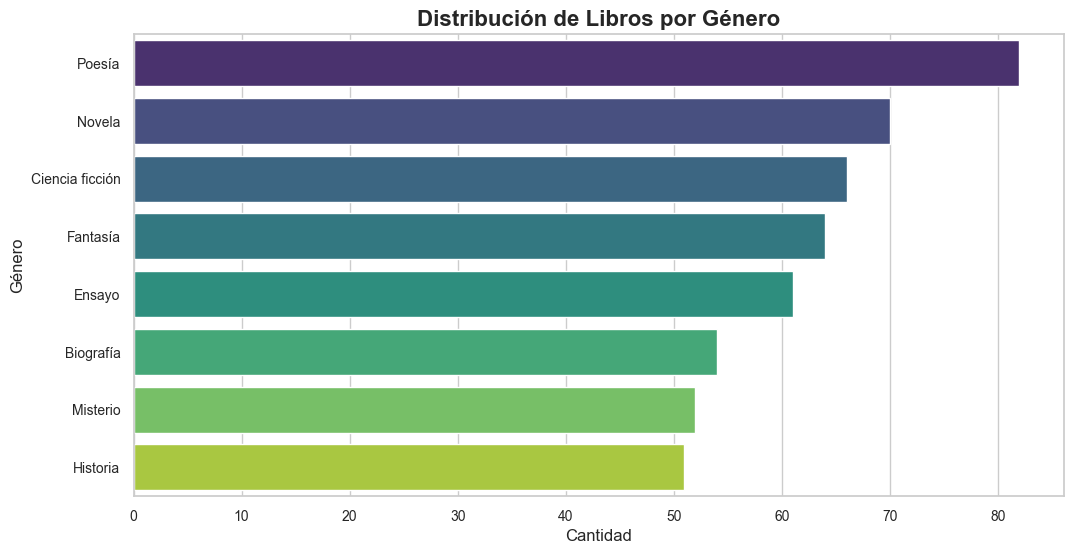

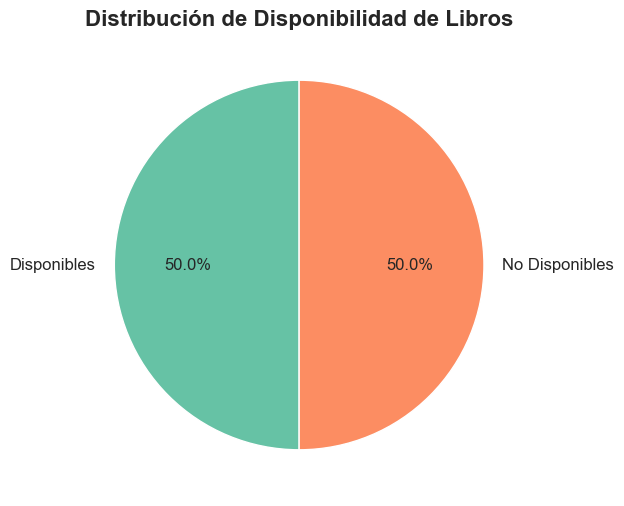

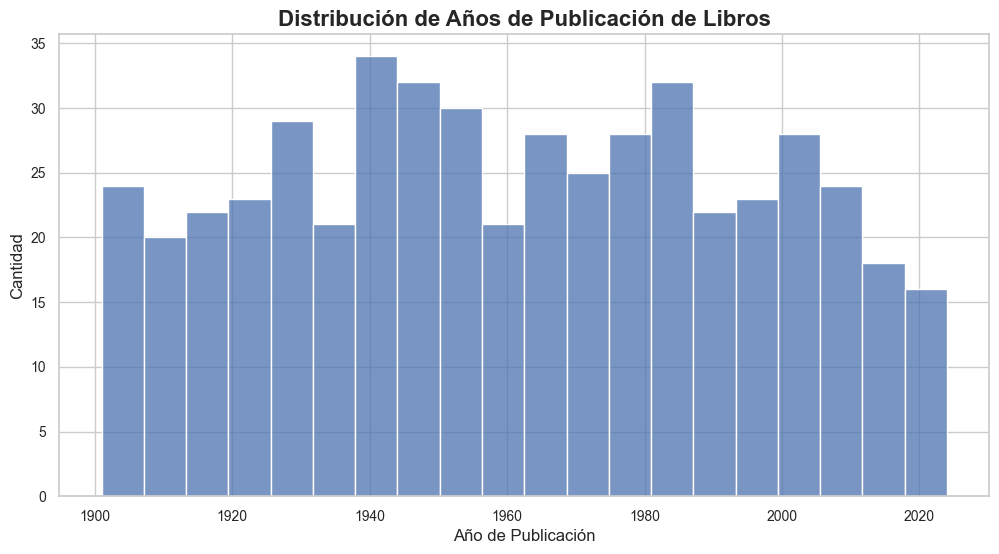

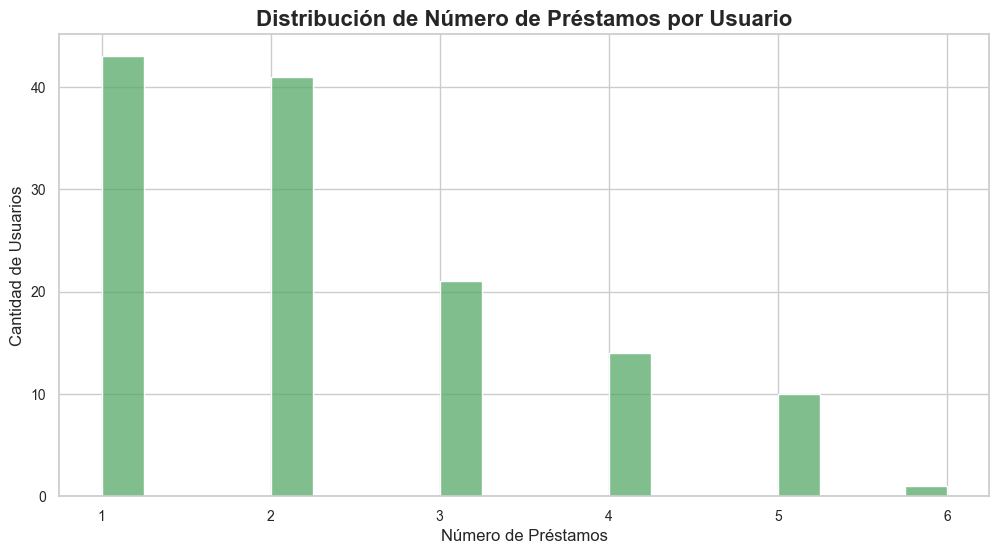

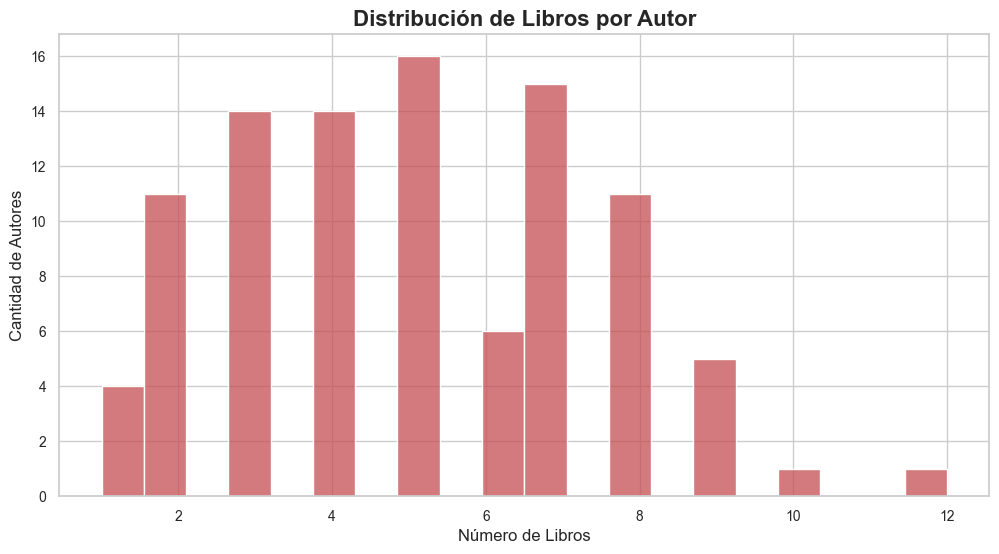

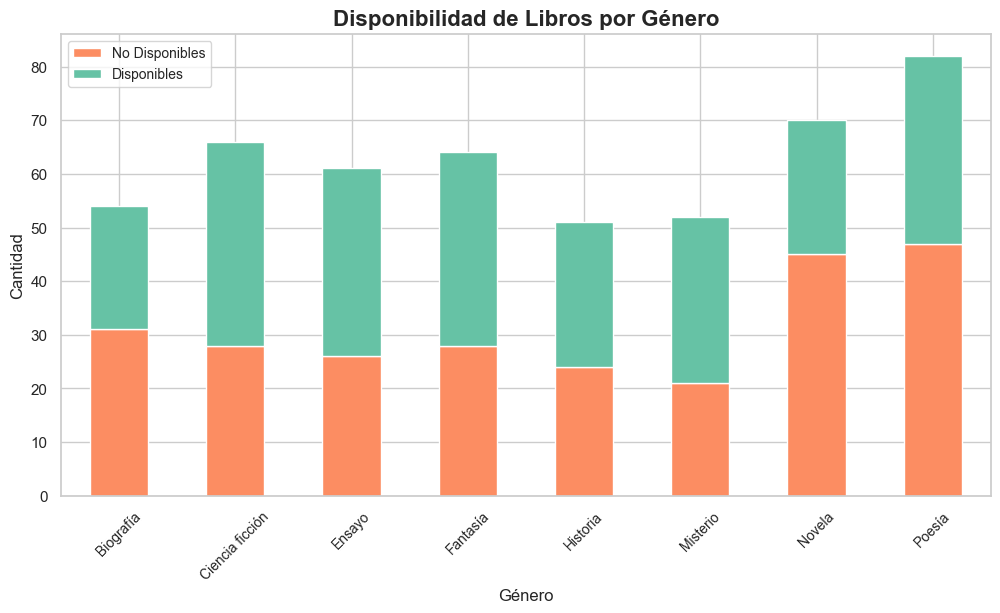

C:\Users\edupe\AppData\Local\Temp\ipykernel_27556\2530036551.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prestamos_por_mes.index, y=prestamos_por_mes.values, palette='coolwarm')


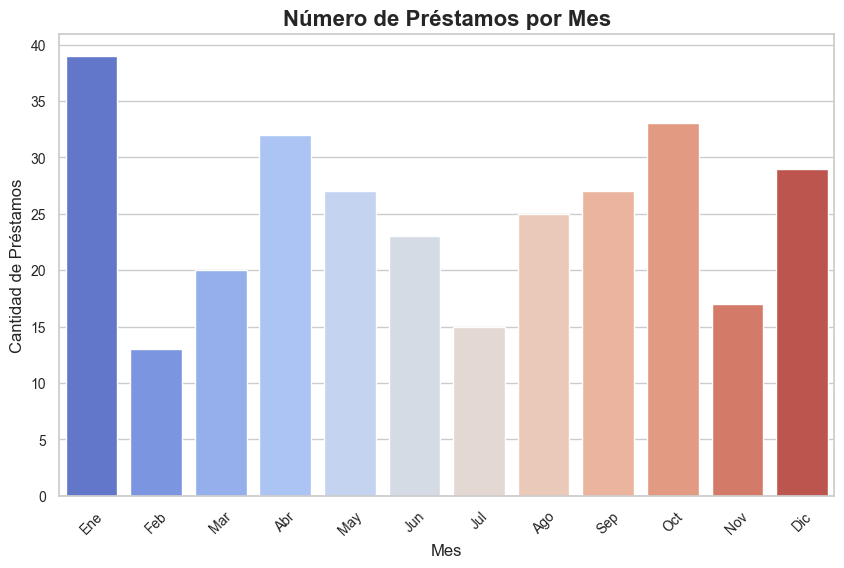

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

# Configurar estilo de Seaborn
sns.set_theme(style="whitegrid")

# Conectar a la base de datos
conn = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="PruebaEstu2012",
    database="Biblioteca"
)

# Cargar datos
libros = pd.read_sql("SELECT * FROM Libros;", conn)
usuarios = pd.read_sql("SELECT * FROM Usuarios;", conn)
prestamos = pd.read_sql("SELECT * FROM Prestamos;", conn)
autores = pd.read_sql("SELECT * FROM Autores;", conn)

conn.close()

# Visualización: Libros por género
plt.figure(figsize=(12, 6))
sns.countplot(data=libros, y='genero', palette='viridis', order=libros['genero'].value_counts().index)
plt.title('Distribución de Libros por Género', fontsize=16, weight='bold')
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Género', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Visualización: Libros por disponibilidad
plt.figure(figsize=(8, 6))
libros['disponible'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', startangle=90, labels=['Disponibles', 'No Disponibles'], 
    colors=['#66c2a5', '#fc8d62'], textprops={'fontsize': 12})
plt.title('Distribución de Disponibilidad de Libros', fontsize=16, weight='bold')
plt.ylabel('')
plt.show()

# Visualización: Libros por año de publicación
plt.figure(figsize=(12, 6))
sns.histplot(libros['anio_publicacion'], bins=20, kde=False, color='#4c72b0')
plt.title('Distribución de Años de Publicación de Libros', fontsize=16, weight='bold')
plt.xlabel('Año de Publicación', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Visualización: Préstamos por usuario
prestamos_usuario = prestamos.groupby('id_usuario').size()
plt.figure(figsize=(12, 6))
sns.histplot(prestamos_usuario, bins=20, kde=False, color='#55a868')
plt.title('Distribución de Número de Préstamos por Usuario', fontsize=16, weight='bold')
plt.xlabel('Número de Préstamos', fontsize=12)
plt.ylabel('Cantidad de Usuarios', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Relación entre autores y libros
autores_libros = libros.groupby('id_autor').size()
plt.figure(figsize=(12, 6))
sns.histplot(autores_libros, bins=20, kde=False, color='#c44e52')
plt.title('Distribución de Libros por Autor', fontsize=16, weight='bold')
plt.xlabel('Número de Libros', fontsize=12)
plt.ylabel('Cantidad de Autores', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Relación entre género y disponibilidad
genero_disponibilidad = libros.groupby(['genero', 'disponible']).size().unstack()
genero_disponibilidad.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#fc8d62', '#66c2a5'])
plt.title('Disponibilidad de Libros por Género', fontsize=16, weight='bold')
plt.xlabel('Género', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(['No Disponibles', 'Disponibles'], fontsize=10)
plt.show()

# Visualización: Préstamos por mes
prestamos['fecha_prestamo'] = pd.to_datetime(prestamos['fecha_prestamo'])
prestamos['mes'] = prestamos['fecha_prestamo'].dt.month
prestamos_por_mes = prestamos.groupby('mes').size()

plt.figure(figsize=(10, 6))
sns.barplot(x=prestamos_por_mes.index, y=prestamos_por_mes.values, palette='coolwarm')
plt.title('Número de Préstamos por Mes', fontsize=16, weight='bold')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Cantidad de Préstamos', fontsize=12)
plt.xticks(ticks=range(12), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()


Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.48      0.39      0.43        51
           1       0.47      0.55      0.50        49

    accuracy                           0.47       100
   macro avg       0.47      0.47      0.47       100
weighted avg       0.47      0.47      0.47       100



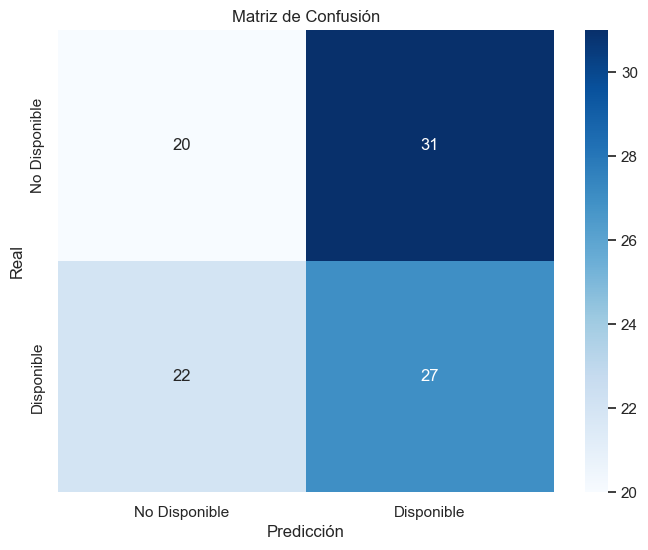

Coeficientes del Modelo:
                  Feature  Coeficiente
1  genero_Ciencia ficción     0.562825
5         genero_Misterio     0.525979
3         genero_Fantasía     0.369710
2           genero_Ensayo     0.351262
4         genero_Historia     0.248626
0        anio_publicacion    -0.005576
7           genero_Poesía    -0.320180
6           genero_Novela    -0.523269


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesamiento de datos
libros = pd.get_dummies(libros, columns=["genero"], drop_first=True)  # Codificación one-hot para género
X = libros.drop(["id_libro", "titulo", "id_autor", "disponible"], axis=1)  # Variables predictoras
y = libros["disponible"]  # Variable objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de Regresión Logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
print("Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Disponible", "Disponible"], yticklabels=["No Disponible", "Disponible"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Coeficientes del modelo
coeficientes = pd.DataFrame({
    "Feature": X.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

print("Coeficientes del Modelo:")
print(coeficientes)
